In [ ]:
!pip install imagecodecs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 39.9 MB/s eta 0:00:00


In [ ]:
from skimage.io import imread
from skimage.measure import regionprops
import pandas as pd
import numpy as np

# === Load image and mask ===
image = imread('/content/drive/MyDrive/APPLIED DATA SCIENCE/downsampled_data/r01c01f01_median_aggregated.tiff')
mask = imread('/content/drive/MyDrive/APPLIED DATA SCIENCE/downsampled_data/Masks/MASK_r01c01f01_median_aggregated.tif')

# === Extract valid region properties using regionprops ===
regions = regionprops(mask, intensity_image=image)

data = []
for r in regions:
    # Basic measurements
    area = r.area
    perimeter = r.perimeter
    eccentricity = r.eccentricity
    solidity = r.solidity
    orientation = r.orientation
    mean_intensity = r.mean_intensity
    max_intensity = r.max_intensity
    min_intensity = r.min_intensity
    extent = r.extent
    feret_diameter_max = r.feret_diameter_max
    major_axis_length = r.major_axis_length
    minor_axis_length = r.minor_axis_length
    equivalent_diameter = r.equivalent_diameter
    bbox_area = (r.bbox[2] - r.bbox[0]) * (r.bbox[3] - r.bbox[1])
    convex_area = r.convex_area

    # Derived features
    aspect_ratio = major_axis_length / minor_axis_length if minor_axis_length != 0 else 0
    roundness = 4 * area / (np.pi * major_axis_length ** 2) if major_axis_length != 0 else 0
    circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0

    # Hu moments (7 values)
    hu = r.moments_hu  # This is an array of 7 values

    # Collect row
    data.append([
        area, perimeter, eccentricity, solidity, orientation,
        mean_intensity, max_intensity, min_intensity, extent,
        feret_diameter_max, major_axis_length, minor_axis_length,
        equivalent_diameter, bbox_area, convex_area,
        aspect_ratio, roundness, circularity,
        *hu  # unpack Hu moments
    ])

# === Column names
columns = [
    'area', 'perimeter', 'eccentricity', 'solidity', 'orientation',
    'mean_intensity', 'max_intensity', 'min_intensity', 'extent',
    'feret_diameter_max', 'major_axis_length', 'minor_axis_length',
    'equivalent_diameter', 'bbox_area', 'convex_area',
    'aspect_ratio', 'roundness', 'circularity',
    'hu_0', 'hu_1', 'hu_2', 'hu_3', 'hu_4', 'hu_5', 'hu_6'
]

# === Create DataFrame
df_cells = pd.DataFrame(data, columns=columns)

# === Optional: aggregate to image level
# === Aggregate to image level ===
if not df_cells.empty:
    agg_df = df_cells.agg(['mean', 'std'])
    agg_df.columns = ['{}_{}'.format(*col) if isinstance(col, tuple) else str(col) for col in agg_df.columns]
    agg_df
    agg_df = pd.DataFrame([agg_df.iloc[0]])
    agg_df['image_id'] = 'r01c01f01'
else:
    print("⚠️ No cells detected in the mask.")
    agg_df = pd.DataFrame()

agg_df


,area,perimeter,eccentricity,solidity,orientation,mean_intensity,max_intensity,min_intensity,extent,feret_diameter_max,...,roundness,circularity,hu_0,hu_1,hu_2,hu_3,hu_4,hu_5,hu_6,image_id
mean,1945.132867,183.357667,0.735906,0.912637,-0.016403,30.641974,80.664336,11.678322,0.635997,65.80914,...,0.604813,0.687683,0.198283,0.012026,0.001536,0.000481,0.000007,0.000116,-1.537197e-07,r01c01f01


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/APPLIED DATA SCIENCE/downsampled_data/analysis/all_image_features.csv')

In [ ]:
len(df1)

NameError: name 'df1' is not defined

# Process all features

In [ ]:
import os
import pandas as pd
import numpy as np
from skimage.io import imread
from skimage.measure import regionprops
from tqdm import tqdm

# === Paths ===
image_dir = '/content/drive/MyDrive/APPLIED DATA SCIENCE/downsampled_data'
mask_dir = os.path.join(image_dir, 'Masks')
save_path = '/content/drive/MyDrive/APPLIED DATA SCIENCE/project 2 model/feature'
os.makedirs(save_path, exist_ok=True)

# === Get all image filenames ===
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tiff') and not f.startswith('._')])

# === Feature container ===
all_features = []

# === Loop through all images ===
for image_file in tqdm(image_files):
    image_path = os.path.join(image_dir, image_file)
    mask_path = os.path.join(mask_dir, 'MASK_' + image_file.replace('.tiff', '.tif'))

    if not os.path.exists(mask_path):
        print(f"⚠️ Skipping {image_file} — mask not found.")
        continue

    try:
        image = imread(image_path)
        mask = imread(mask_path)

        regions = regionprops(mask, intensity_image=image)
        data = []

        for r in regions:
            area = r.area
            perimeter = r.perimeter
            eccentricity = r.eccentricity
            solidity = r.solidity
            orientation = r.orientation
            mean_intensity = r.mean_intensity
            max_intensity = r.max_intensity
            min_intensity = r.min_intensity
            extent = r.extent
            feret_diameter_max = r.feret_diameter_max
            major_axis_length = r.major_axis_length
            minor_axis_length = r.minor_axis_length
            equivalent_diameter = r.equivalent_diameter
            bbox_area = (r.bbox[2] - r.bbox[0]) * (r.bbox[3] - r.bbox[1])
            convex_area = r.convex_area

            aspect_ratio = major_axis_length / minor_axis_length if minor_axis_length != 0 else 0
            roundness = 4 * area / (np.pi * major_axis_length ** 2) if major_axis_length != 0 else 0
            circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0

            hu = r.moments_hu

            data.append([
                area, perimeter, eccentricity, solidity, orientation,
                mean_intensity, max_intensity, min_intensity, extent,
                feret_diameter_max, major_axis_length, minor_axis_length,
                equivalent_diameter, bbox_area, convex_area,
                aspect_ratio, roundness, circularity,
                *hu
            ])

        columns = [
            'area', 'perimeter', 'eccentricity', 'solidity', 'orientation',
            'mean_intensity', 'max_intensity', 'min_intensity', 'extent',
            'feret_diameter_max', 'major_axis_length', 'minor_axis_length',
            'equivalent_diameter', 'bbox_area', 'convex_area',
            'aspect_ratio', 'roundness', 'circularity',
            'hu_0', 'hu_1', 'hu_2', 'hu_3', 'hu_4', 'hu_5', 'hu_6'
        ]

        df_cells = pd.DataFrame(data, columns=columns)

        if df_cells.empty:
            print(f"⚠️ No objects found in mask: {image_file}")
            continue

        # Aggregate to image-level (mean/std), flatten columns
        agg_df = df_cells.agg(['mean', 'std'])
        agg_df.columns = ['{}_{}'.format(*col) if isinstance(col, tuple) else str(col) for col in agg_df.columns]
        agg_df = pd.DataFrame([agg_df.iloc[0]])  # Keep only the mean row
        agg_df['image_id'] = image_file.replace('.tiff', '')

        all_features.append(agg_df)

    except Exception as e:
        print(f"❌ Error processing {image_file}: {e}")

# === Combine and save ===
df_all = pd.concat(all_features, ignore_index=True)
df_all.to_csv(os.path.join(save_path, 'image_features.csv'), index=False)
print(f"✅ Saved {len(df_all)} image-wise features to: image_features.csv")


100%|██████████| 2867/2867 [34:37<00:00,  1.38it/s]


✅ Saved 2867 image-wise features to: image_features.csv


# Read and aggregate meta with the feature data

In [ ]:
import pandas as pd

# === Load data ===
df_all = pd.read_csv('/content/drive/MyDrive/APPLIED DATA SCIENCE/project 2 model/feature/image_features.csv')
meta = pd.read_csv('/content/drive/MyDrive/APPLIED DATA SCIENCE/downsampled_data/metadata/metadata_BR00116991 (1).csv')

# === Extract core image_id from filenames ===
df_all['image_id'] = df_all['image_id'].str.extract(r'^(r\d{2}c\d{2}f\d{2})')
meta['image_id'] = meta['FileName_OrigRNA'].str.extract(r'^(r\d{2}c\d{2}f\d{2})')

# === Get one row per image with compound name ===
meta_compound = meta[['image_id', 'Metadata_pert_iname']].dropna().drop_duplicates(subset='image_id')

# === Merge features with perturbation (compound) labels ===
df_labeled = pd.merge(df_all, meta_compound, on='image_id', how='left')

# === Drop unmatched (if any) ===
df_labeled = df_labeled.dropna(subset=['Metadata_pert_iname'])

# ✅ df_labeled is now ready for training, EDA, etc.
df_labeled


,area,perimeter,eccentricity,solidity,orientation,mean_intensity,max_intensity,min_intensity,extent,feret_diameter_max,...,circularity,hu_0,hu_1,hu_2,hu_3,hu_4,hu_5,hu_6,image_id,Metadata_pert_iname
0,1945.132867,183.357667,0.735906,0.912637,-0.016403,30.641974,80.664336,11.678322,0.635997,65.809140,...,0.687683,0.198283,0.012026,0.001536,0.000481,7.467654e-06,0.000116,-1.537197e-07,r01c01f01,gabapentin-enacarbil
1,1412.000000,150.816700,0.726133,0.922601,0.019310,32.267090,62.765403,15.296209,0.656493,54.897594,...,0.727373,0.193159,0.010313,0.000857,0.000099,9.583412e-08,0.000010,-9.116634e-09,r01c01f02,gabapentin-enacarbil
2,2538.660256,216.594371,0.752340,0.895236,0.015427,27.252494,83.198718,9.775641,0.619226,76.144348,...,0.640614,0.203402,0.013249,0.001594,0.000277,1.342695e-06,0.000041,-4.427079e-07,r01c01f03,gabapentin-enacarbil
3,3510.280000,258.022021,0.782227,0.876990,0.002510,24.333679,85.840000,6.820000,0.596692,92.443084,...,0.607830,0.214410,0.017821,0.001795,0.000257,6.970506e-07,0.000022,-3.981841e-07,r01c01f04,gabapentin-enacarbil
4,1662.707692,163.199656,0.732244,0.924870,0.051322,32.934432,70.538462,14.810256,0.667012,58.761531,...,0.727626,0.191874,0.010536,0.000708,0.000134,2.915060e-07,0.000020,-1.179751e-08,r01c01f05,gabapentin-enacarbil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,2331.059172,198.519245,0.699816,0.916928,0.033233,33.576322,103.911243,11.497041,0.646189,70.080890,...,0.705483,0.188876,0.008230,0.000871,0.000085,9.214033e-08,0.000007,1.901710e-09,r14c07f01,DMSO
2863,2237.364407,199.401776,0.726421,0.903023,0.031551,31.534624,95.733051,10.419492,0.631258,71.585387,...,0.671452,0.197312,0.011568,0.001125,0.000187,6.215240e-07,0.000024,-6.265752e-08,r14c07f02,DMSO
2864,3248.423529,249.468409,0.713611,0.890491,-0.013676,30.601285,110.352941,7.941176,0.617803,88.109749,...,0.629877,0.200757,0.011592,0.001334,0.000161,2.019336e-07,0.000016,3.331418e-08,r14c07f03,DMSO
2865,2316.732824,201.188415,0.739280,0.905447,0.017125,35.517142,107.007634,10.969466,0.630843,73.290359,...,0.670952,0.200736,0.013270,0.001259,0.000193,1.038023e-06,0.000029,4.127002e-08,r14c07f04,DMSO


# EDA

<ipython-input-76-b94643efa2f7>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


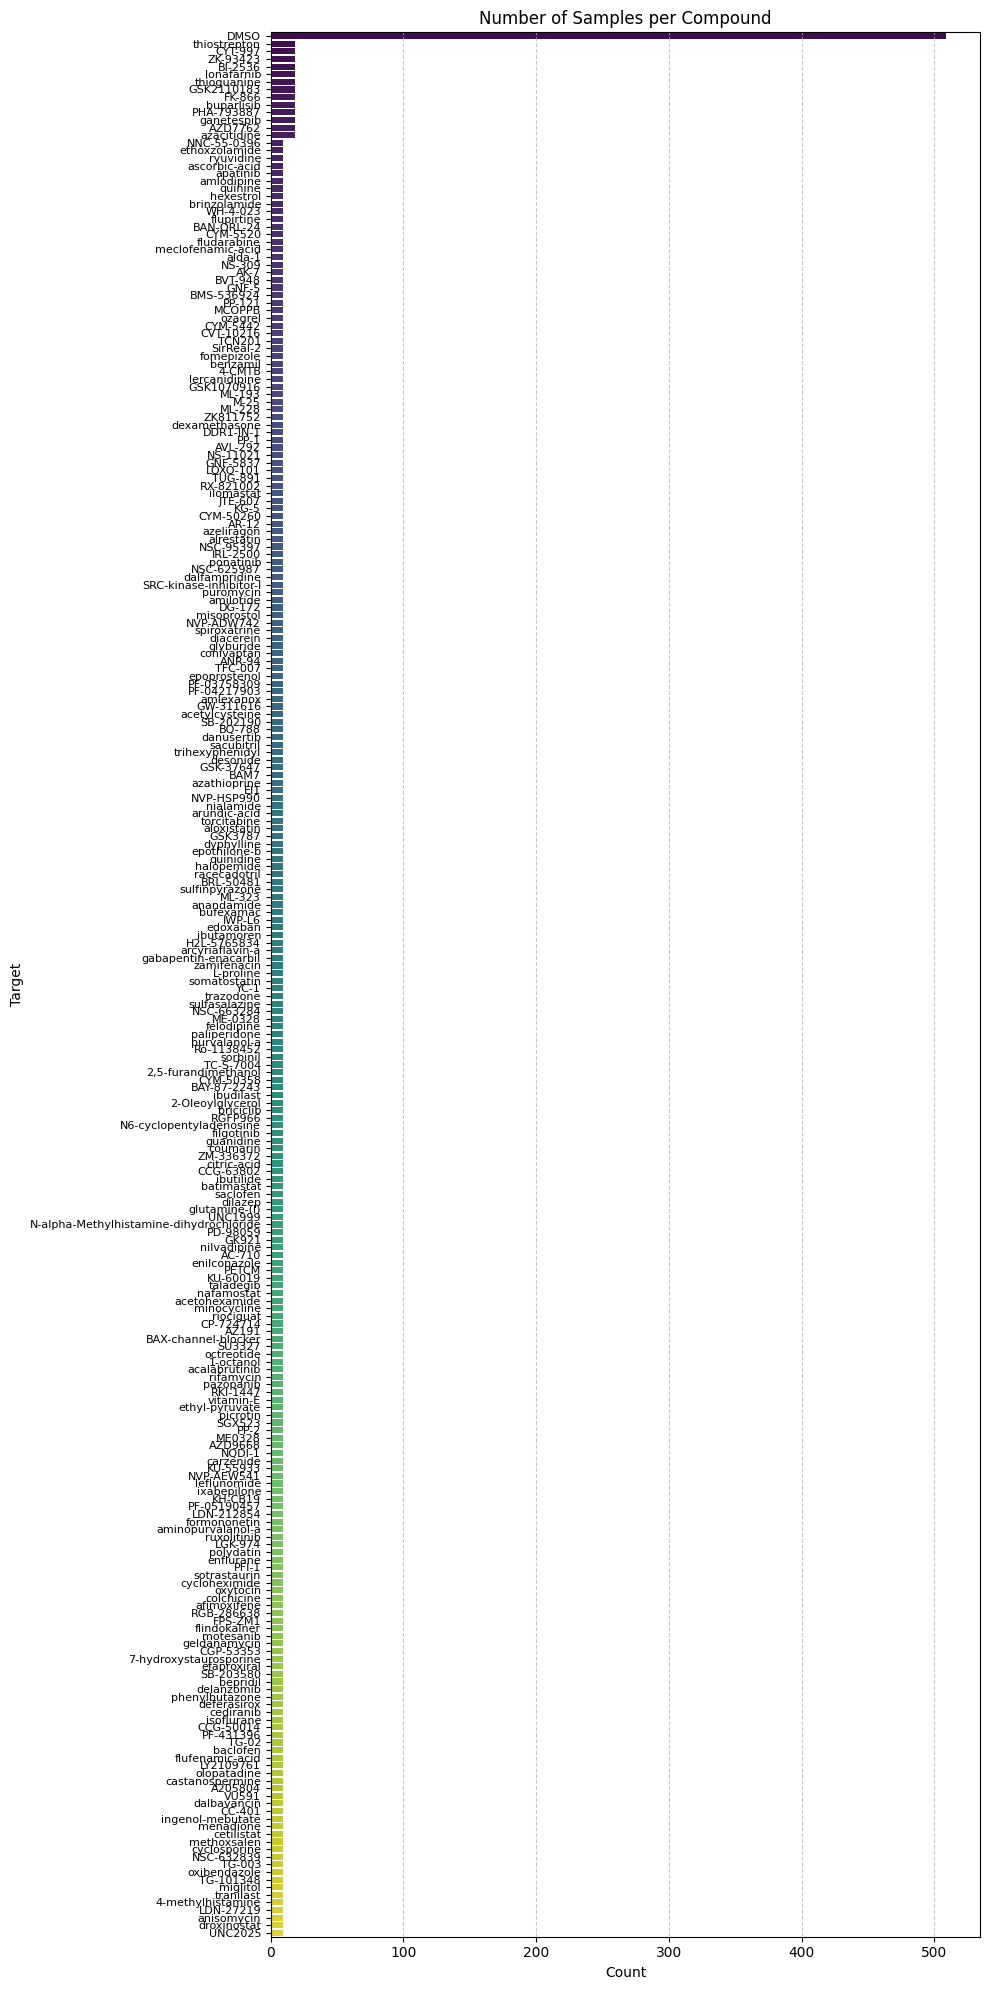

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 20))  # Tall figure for vertical layout
sns.countplot(
    y='Metadata_pert_iname',
    data=df_labeled,
    order=df_labeled['Metadata_pert_iname'].value_counts().index,
    palette='viridis'
)
plt.title('Number of Samples per Compound')
plt.xlabel('Count')
plt.ylabel('Target')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

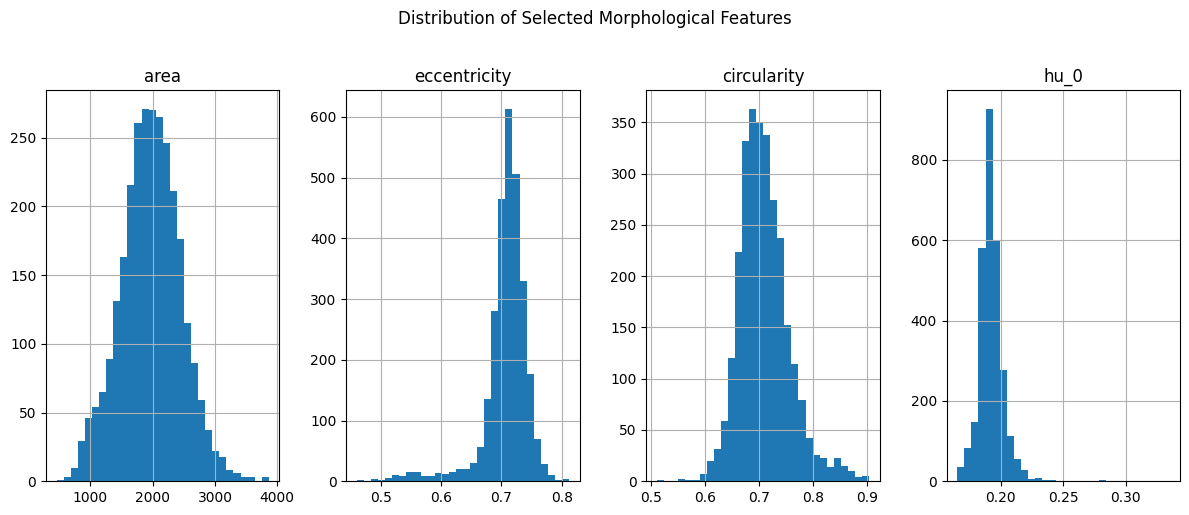

In [ ]:
features_to_plot = ['area', 'eccentricity', 'circularity', 'hu_0']
df_labeled[features_to_plot].hist(bins=30, figsize=(12, 5), layout=(1, 4))
plt.suptitle('Distribution of Selected Morphological Features', y=1.02)
plt.tight_layout()
plt.show()

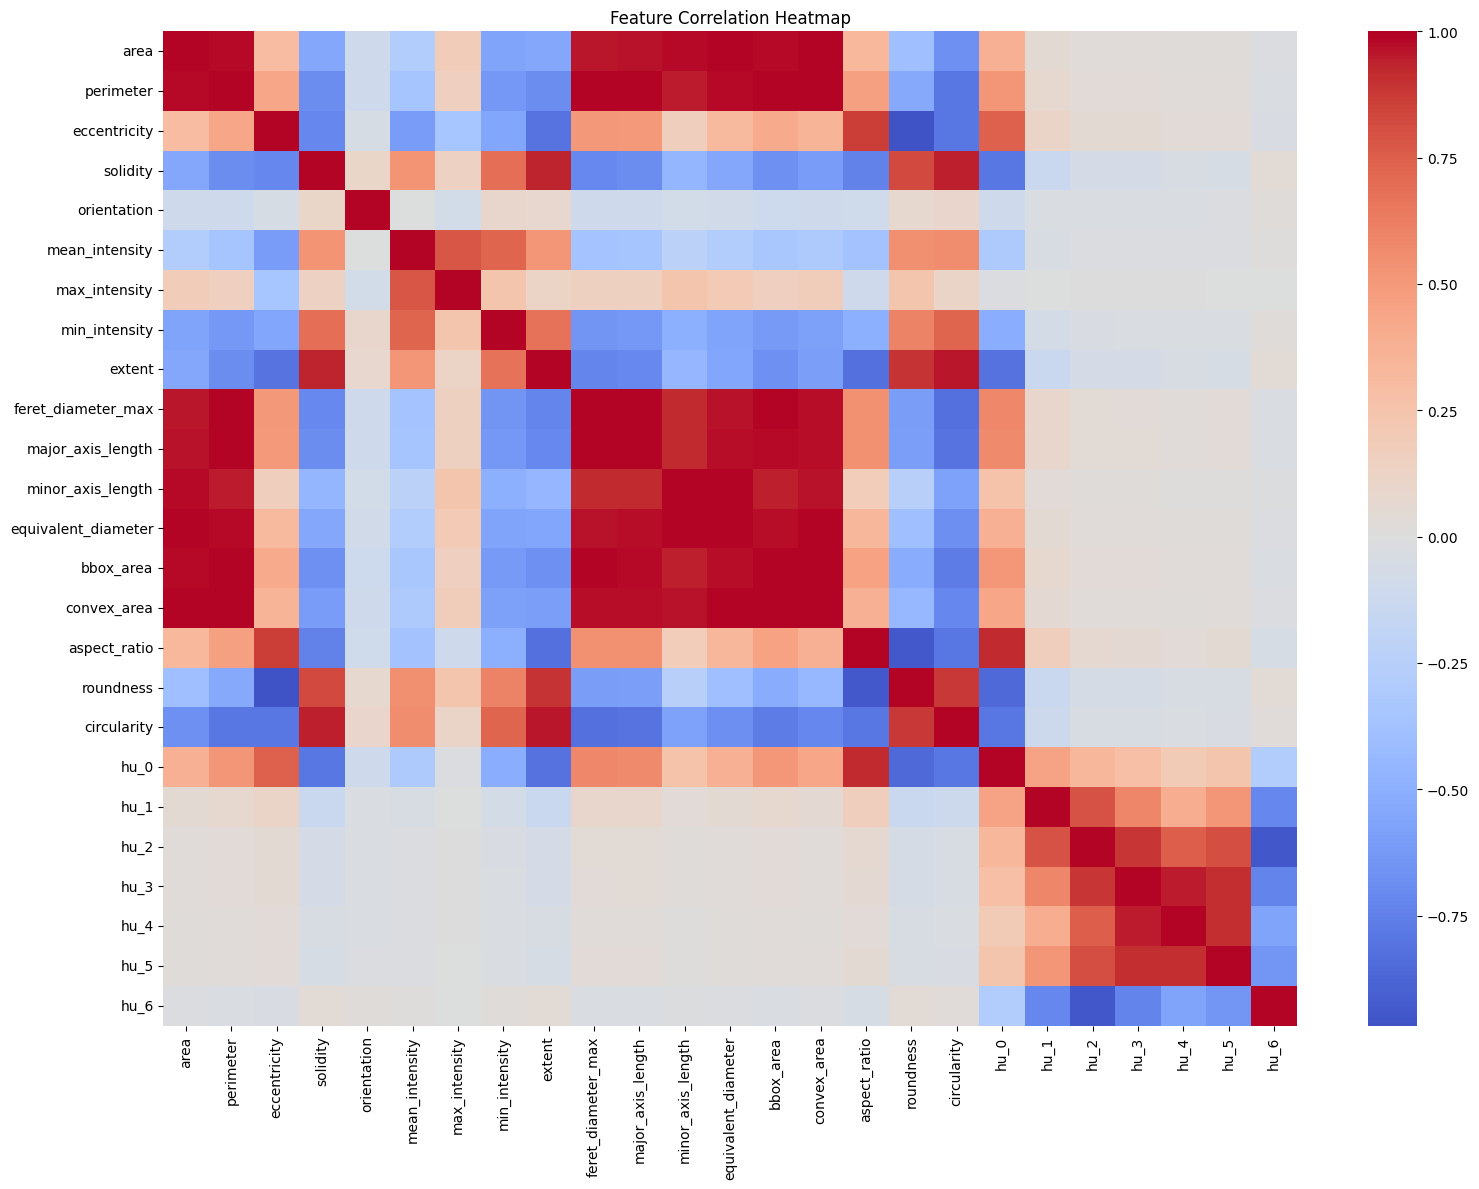

In [ ]:
plt.figure(figsize=(16, 12))
corr = df_labeled.drop(columns=['image_id', 'Metadata_pert_iname']).corr()
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

<ipython-input-88-cf81dcc0be9a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


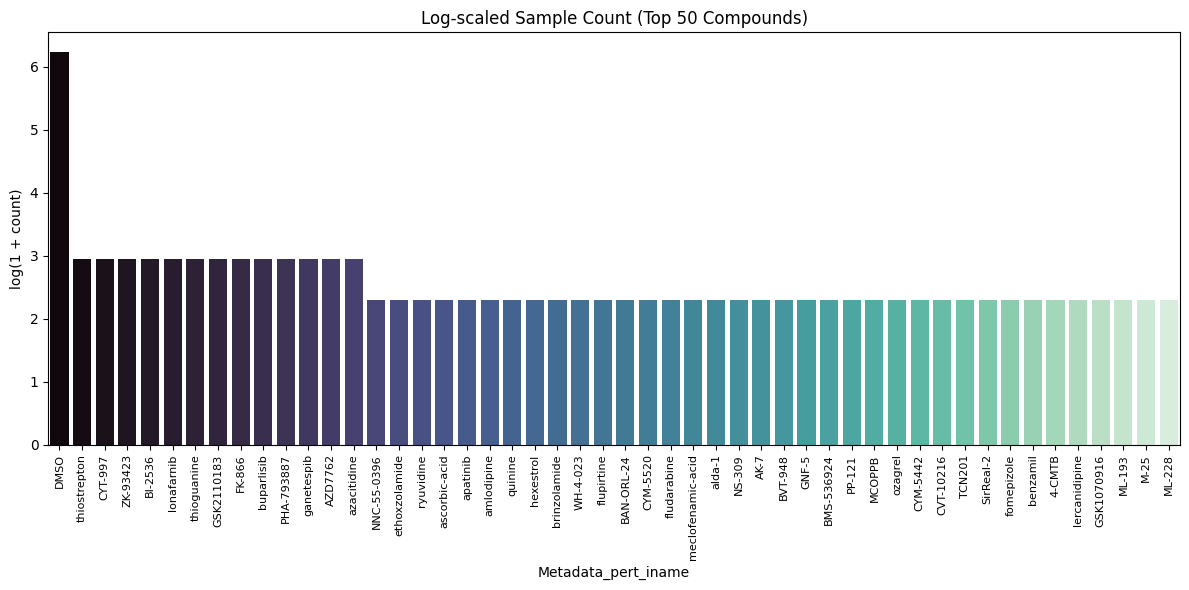

In [ ]:
counts = df_labeled['Metadata_pert_iname'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(
    x=counts.index[:50],  # Top 50 only
    y=np.log1p(counts.values[:50]),
    palette='mako'
)
plt.xticks(rotation=90, fontsize=8)
plt.title("Log-scaled Sample Count (Top 50 Compounds)")
plt.ylabel("log(1 + count)")
plt.tight_layout()
plt.show()

# PCA/tSNE/UMAP

## TSNE

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


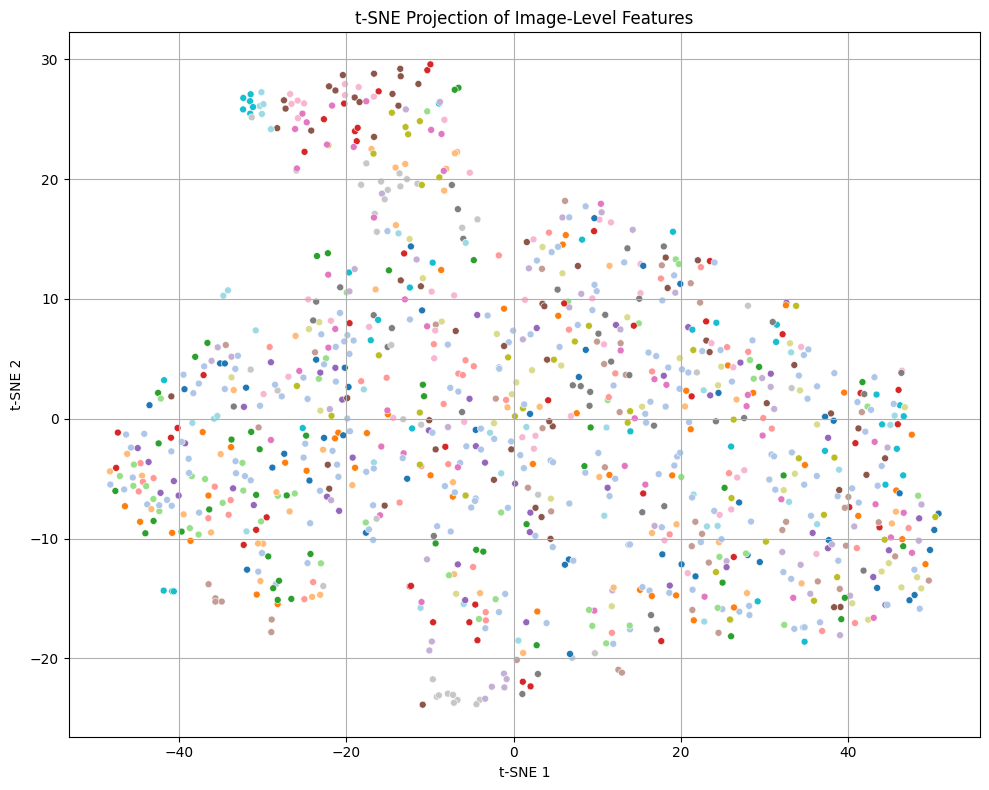

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Prepare features and labels ---
feature_cols = [col for col in df_labeled.columns if col not in ['image_id', 'Metadata_pert_iname']]
X = df_labeled[feature_cols]
y = df_labeled['Metadata_pert_iname']

# --- 2. Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Run t-SNE (on a sample if dataset is large) ---
sample_size = 1000
X_sample = X_scaled[:sample_size]
y_sample = y[:sample_size]

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

# --- 4. Plot ---
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y_sample,
    palette='tab20',
    s=25,
    legend=False
)
plt.title("t-SNE Projection of Image-Level Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()


## UMAP

In [ ]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


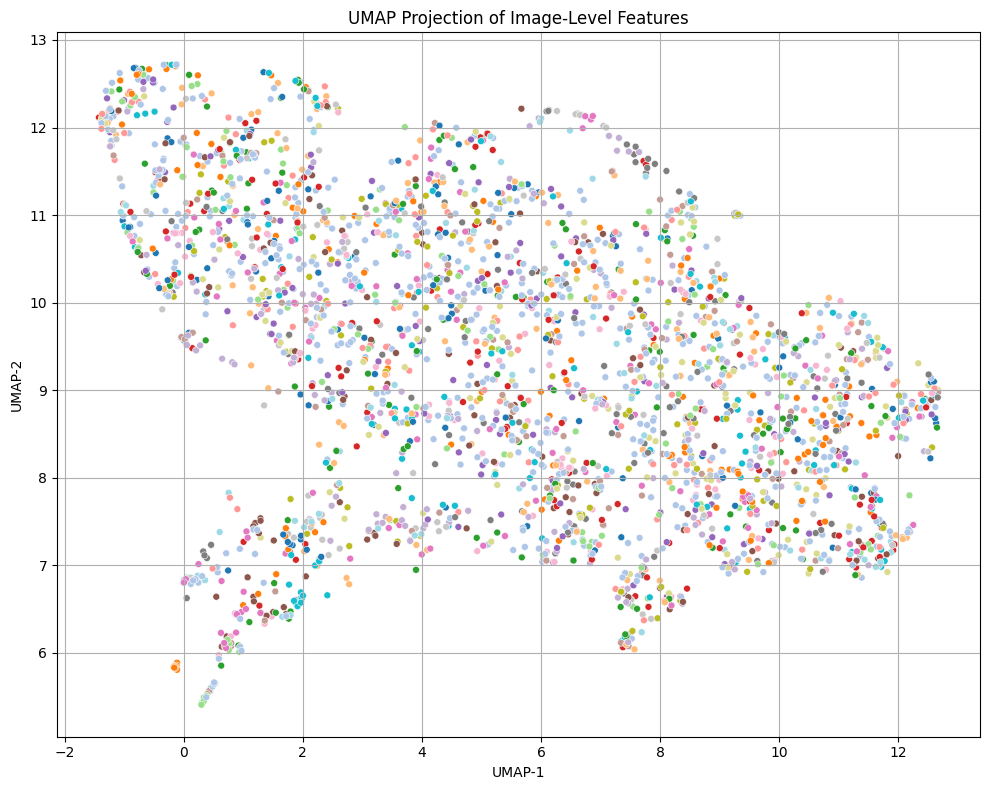

In [ ]:
# --- 1. Prepare features and labels ---
feature_cols = [col for col in df_labeled.columns if col not in ['image_id', 'Metadata_pert_iname']]
X = df_labeled[feature_cols]
y = df_labeled['Metadata_pert_iname']

# --- 2. Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Run UMAP (on a sample for speed)
X_sample = X_scaled
y_sample = y

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_sample)

# --- 4. Plot ---
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=y_sample,
    palette='tab20',
    s=25,
    legend=False
)
plt.title("UMAP Projection of Image-Level Features")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.tight_layout()
plt.show()


# Data Split

In [ ]:
from sklearn.model_selection import train_test_split
import os
import pandas as pd

# === Set output path ===
split_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/project 2 model/data split"
os.makedirs(split_dir, exist_ok=True)

# === Step 1: Initial train-test split (80% train_val / 20% test) ===
train_val_df, test_df = train_test_split(
    df_labeled,
    test_size=0.2,
    stratify=df_labeled['Metadata_pert_iname'],
    random_state=42
)

# === Step 2: Train-Validation split from train_val ===
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,  # 20% of 80% → 16% of total
    stratify=train_val_df['Metadata_pert_iname'],
    random_state=42
)

# === Step 3: Save to CSV ===
train_df.to_csv(f"{split_dir}/train.csv", index=False)
val_df.to_csv(f"{split_dir}/val.csv", index=False)
test_df.to_csv(f"{split_dir}/test.csv", index=False)

print("✅ Data split complete and saved.")


✅ Data split complete and saved.


# XGBoost



[0]	validation_0-mlogloss:5.32221
[1]	validation_0-mlogloss:5.18112
[2]	validation_0-mlogloss:5.08550
[3]	validation_0-mlogloss:5.00917
[4]	validation_0-mlogloss:4.95134
[5]	validation_0-mlogloss:4.91985
[6]	validation_0-mlogloss:4.88723
[7]	validation_0-mlogloss:4.86104
[8]	validation_0-mlogloss:4.84600
[9]	validation_0-mlogloss:4.82879
[10]	validation_0-mlogloss:4.81601
[11]	validation_0-mlogloss:4.80679
[12]	validation_0-mlogloss:4.79498
[13]	validation_0-mlogloss:4.79089
[14]	validation_0-mlogloss:4.78582
[15]	validation_0-mlogloss:4.77430
[16]	validation_0-mlogloss:4.76697
[17]	validation_0-mlogloss:4.76145
[18]	validation_0-mlogloss:4.75580
[19]	validation_0-mlogloss:4.74894
[20]	validation_0-mlogloss:4.74123
[21]	validation_0-mlogloss:4.73013
[22]	validation_0-mlogloss:4.72674
[23]	validation_0-mlogloss:4.71928
[24]	validation_0-mlogloss:4.71682
[25]	validation_0-mlogloss:4.71316
[26]	validation_0-mlogloss:4.70672
[27]	validation_0-mlogloss:4.70035
[28]	validation_0-mlogloss:4.6

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
1-octanol,0.00,0.00,0.00,1.00
"2,5-furandimethanol",0.00,0.00,0.00,2.00
2-Oleoylglycerol,0.00,0.00,0.00,1.00
4-CMTB,0.00,0.00,0.00,2.00
4-methylhistamine,0.00,0.00,0.00,1.00
...,...,...,...,...
vitamin-E,0.00,0.00,0.00,1.00
zamifenacin,0.00,0.00,0.00,2.00
accuracy,0.12,0.12,0.12,0.12
macro avg,0.07,0.09,0.07,459.00


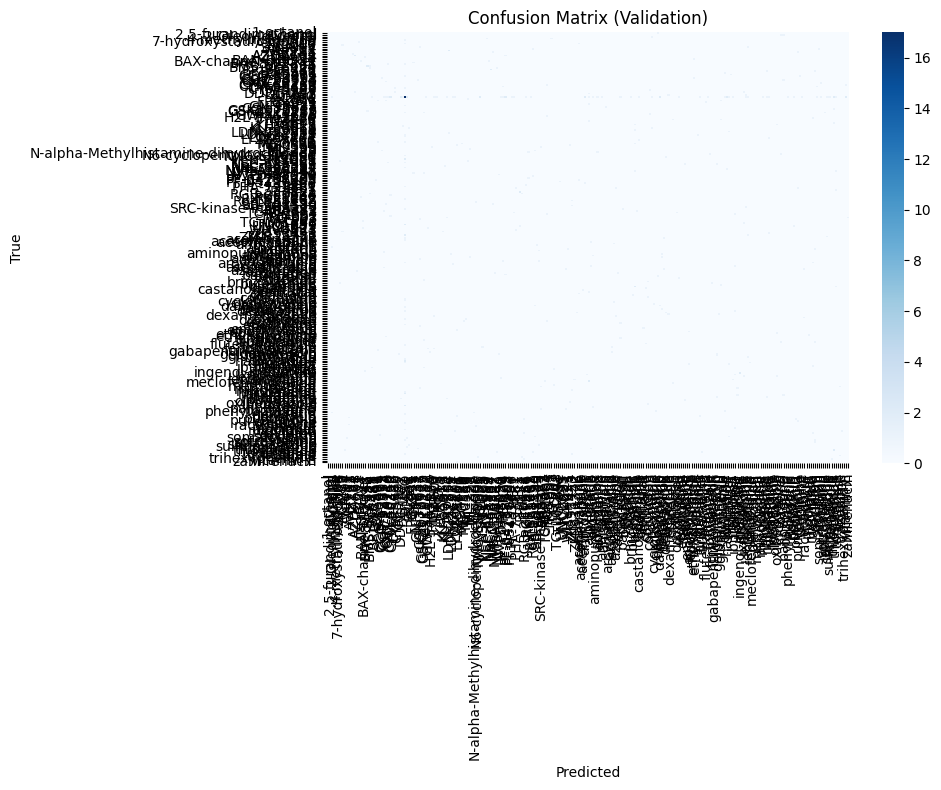

Test Accuracy: 0.1098


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
1-octanol,0.00,0.00,0.00,2.00
"2,5-furandimethanol",0.00,0.00,0.00,2.00
2-Oleoylglycerol,0.00,0.00,0.00,2.00
4-CMTB,0.00,0.00,0.00,2.00
4-methylhistamine,0.00,0.00,0.00,2.00
...,...,...,...,...
vitamin-E,0.00,0.00,0.00,2.00
zamifenacin,0.00,0.00,0.00,2.00
accuracy,0.11,0.11,0.11,0.11
macro avg,0.07,0.07,0.07,574.00


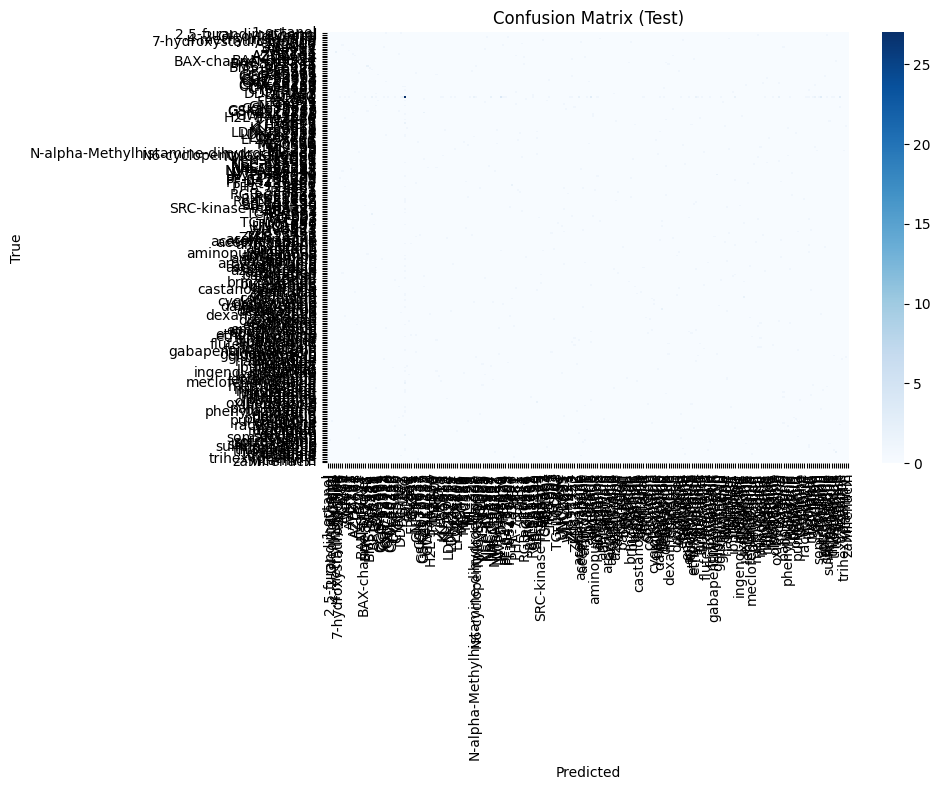

In [ ]:
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Paths ===
split_dir = "/content/drive/MyDrive/APPLIED DATA SCIENCE/project 2 model/data split"

# === Load data ===
train_df = pd.read_csv(f"{split_dir}/train.csv")
val_df = pd.read_csv(f"{split_dir}/val.csv")
test_df = pd.read_csv(f"{split_dir}/test.csv")

# === Extract features/labels ===
def prepare_X_y(df, le=None):
    X = df.drop(columns=['image_id', 'Metadata_pert_iname'])
    y_raw = df['Metadata_pert_iname']
    if le is None:
        le = LabelEncoder()
        y = le.fit_transform(y_raw)
    else:
        y = le.transform(y_raw)
    return X, y, le

X_train, y_train, le = prepare_X_y(train_df)
X_val, y_val, _ = prepare_X_y(val_df, le)
X_test, y_test, _ = prepare_X_y(test_df, le)

# === Compute class weights ===
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# === Train XGBoost ===
model = XGBClassifier(
    eval_metric='mlogloss',
    random_state=4,
    n_estimators=200  # fixed number of trees
)

model.fit(
    X_train,
    y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# === Save model and label encoder ===
model_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/project 2 model/XGBoost_CW"
os.makedirs(model_path, exist_ok=True)
joblib.dump(model, f"{model_path}/xgboost_model.joblib")
joblib.dump(le, f"{model_path}/label_encoder.joblib")

# === Evaluate on val + test ===
def evaluate(model, X, y, name):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

    report = classification_report(y, y_pred, target_names=le.inverse_transform(np.unique(y)), output_dict=True)
    df_report = pd.DataFrame(report).transpose().round(2)
    display(df_report)

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_, annot=False, fmt='d')
    plt.title(f'Confusion Matrix ({name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Run evaluation
evaluate(model, X_val, y_val, name="Validation")
evaluate(model, X_test, y_test, name="Test")


# RF

<ipython-input-133-b5db7ea17e0a>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['pert_encoded'] = le.fit_transform(df_filtered['Metadata_pert_iname'])


Test Accuracy: 0.7919
              precision    recall  f1-score   support

     AZD7762       1.00      0.67      0.80         3
     BI-2536       0.80      1.00      0.89         4
     CYT-997       1.00      0.25      0.40         4
        DMSO       0.79      0.99      0.88       102
      FK-866       0.00      0.00      0.00         4
  GSK2110183       1.00      0.75      0.86         4
  PHA-793887       0.00      0.00      0.00         3
    ZK-93423       0.00      0.00      0.00         4
 azacitidine       1.00      0.25      0.40         4
  buparlisib       0.60      1.00      0.75         3
  ganetespib       0.00      0.00      0.00         3
  lonafarnib       0.00      0.00      0.00         4
 thioguanine       0.50      0.33      0.40         3
thiostrepton       1.00      0.50      0.67         4

    accuracy                           0.79       149
   macro avg       0.55      0.41      0.43       149
weighted avg       0.71      0.79      0.73       149



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


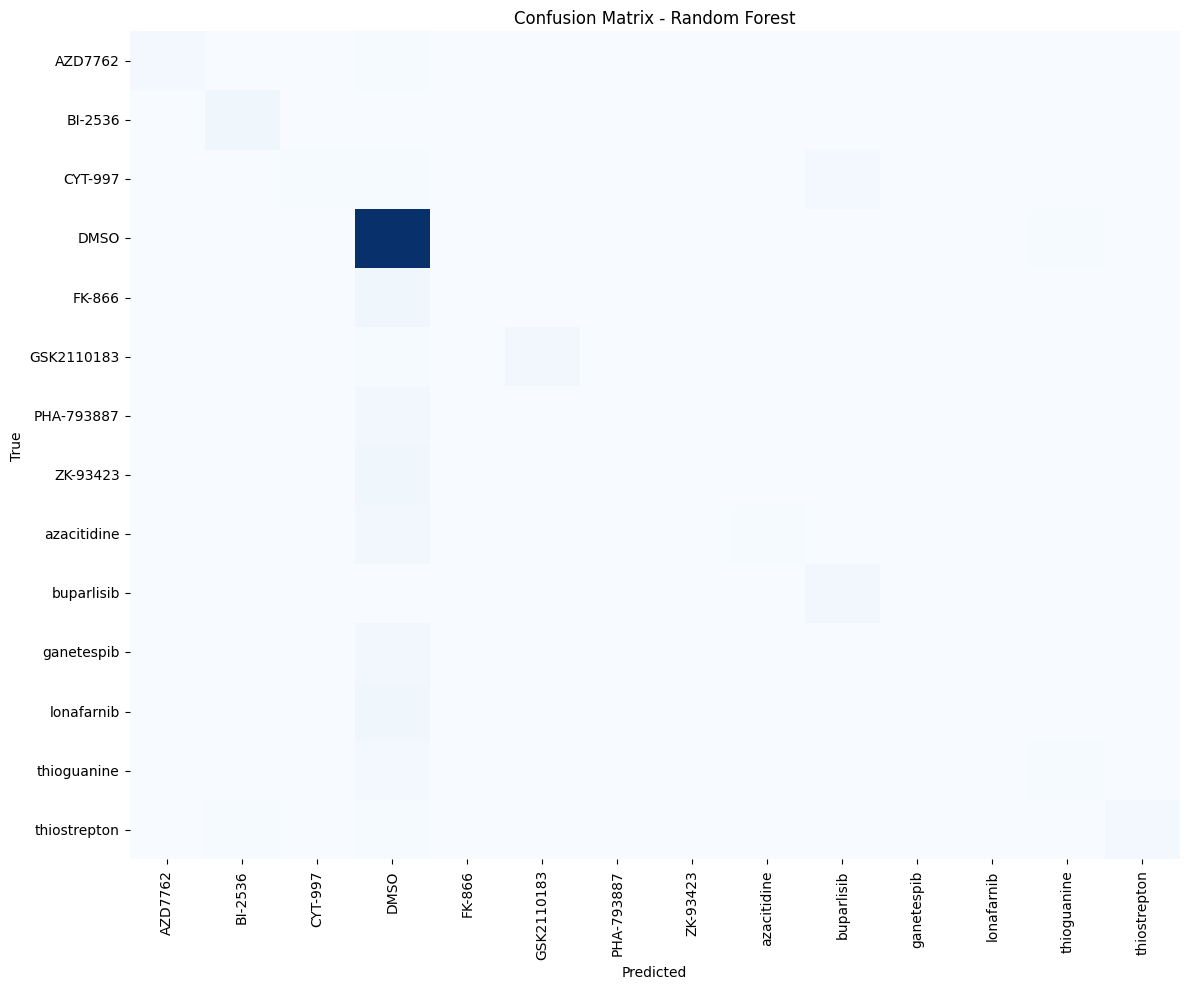

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# === Load data ===
df_all = pd.read_csv('/content/drive/MyDrive/APPLIED DATA SCIENCE/project 2 model/feature/image_features.csv')
meta = pd.read_csv('/content/drive/MyDrive/APPLIED DATA SCIENCE/downsampled_data/metadata/metadata_BR00116991 (1).csv')

# === Extract core image_id from filenames ===
df_all['image_id'] = df_all['image_id'].str.extract(r'^(r\d{2}c\d{2}f\d{2})')
meta['image_id'] = meta['FileName_OrigRNA'].str.extract(r'^(r\d{2}c\d{2}f\d{2})')

# === Get one row per image with compound name ===
meta_compound = meta[['image_id', 'Metadata_pert_iname']].dropna().drop_duplicates(subset='image_id')

# === Merge features with perturbation (compound) labels ===
df_labeled = pd.merge(df_all, meta_compound, on='image_id', how='left')

# === Drop unmatched (if any) ===
df_labeled = df_labeled.dropna(subset=['Metadata_pert_iname'])




# === 1. Filter: keep compounds with >=20 samples
counts = df_labeled['Metadata_pert_iname'].value_counts()
valid_drugs = counts[counts >= 18].index
df_filtered = df_labeled[df_labeled['Metadata_pert_iname'].isin(valid_drugs)]

# === 2. Encode labels
le = LabelEncoder()
df_filtered['pert_encoded'] = le.fit_transform(df_filtered['Metadata_pert_iname'])

# === 3. Split data
X = df_filtered.drop(columns=['image_id', 'Metadata_pert_iname', 'pert_encoded'])
y = df_filtered['pert_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === 4. Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# === 5. Predict & Evaluate
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=le.inverse_transform(np.unique(y_test))))

# === 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
df_filtered

,area,perimeter,eccentricity,solidity,orientation,mean_intensity,max_intensity,min_intensity,extent,feret_diameter_max,...,hu_0,hu_1,hu_2,hu_3,hu_4,hu_5,hu_6,image_id,Metadata_pert_iname,pert_encoded
9,1008.141914,122.977184,0.718225,0.933114,0.030322,38.887121,75.323432,17.696370,0.674292,44.959378,...,0.186534,0.007998,0.000660,0.000086,3.207823e-07,0.000010,-1.031138e-08,r01c02f01,DMSO,3
10,719.280125,103.425354,0.724099,0.933333,0.066813,37.150129,60.527387,19.062598,0.674898,38.229972,...,0.188454,0.008796,0.000747,0.000091,1.063005e-07,0.000007,-1.467009e-08,r01c02f02,DMSO,3
11,2035.562842,191.294823,0.739179,0.902869,0.031525,34.218085,88.825137,12.715847,0.632406,68.487231,...,0.201134,0.013009,0.001403,0.000202,3.660767e-07,0.000022,-1.450992e-07,r01c02f03,DMSO,3
12,1968.961538,190.858389,0.769208,0.905498,0.031561,35.139206,104.711538,11.000000,0.619540,70.401922,...,0.209219,0.016146,0.001637,0.000277,9.682970e-07,0.000047,-9.204643e-08,r01c02f04,DMSO,3
13,1532.901961,159.506046,0.725989,0.920219,0.045397,34.834501,80.282353,13.062745,0.648189,57.872125,...,0.191252,0.009480,0.000884,0.000151,6.030643e-07,0.000026,2.654303e-08,r01c02f05,DMSO,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,2331.059172,198.519245,0.699816,0.916928,0.033233,33.576322,103.911243,11.497041,0.646189,70.080890,...,0.188876,0.008230,0.000871,0.000085,9.214033e-08,0.000007,1.901710e-09,r14c07f01,DMSO,3
2863,2237.364407,199.401776,0.726421,0.903023,0.031551,31.534624,95.733051,10.419492,0.631258,71.585387,...,0.197312,0.011568,0.001125,0.000187,6.215240e-07,0.000024,-6.265752e-08,r14c07f02,DMSO,3
2864,3248.423529,249.468409,0.713611,0.890491,-0.013676,30.601285,110.352941,7.941176,0.617803,88.109749,...,0.200757,0.011592,0.001334,0.000161,2.019336e-07,0.000016,3.331418e-08,r14c07f03,DMSO,3
2865,2316.732824,201.188415,0.739280,0.905447,0.017125,35.517142,107.007634,10.969466,0.630843,73.290359,...,0.200736,0.013270,0.001259,0.000193,1.038023e-06,0.000029,4.127002e-08,r14c07f04,DMSO,3


<ipython-input-106-e44b5991f6ba>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=count_distribution.index, y=count_distribution.values, palette='crest')


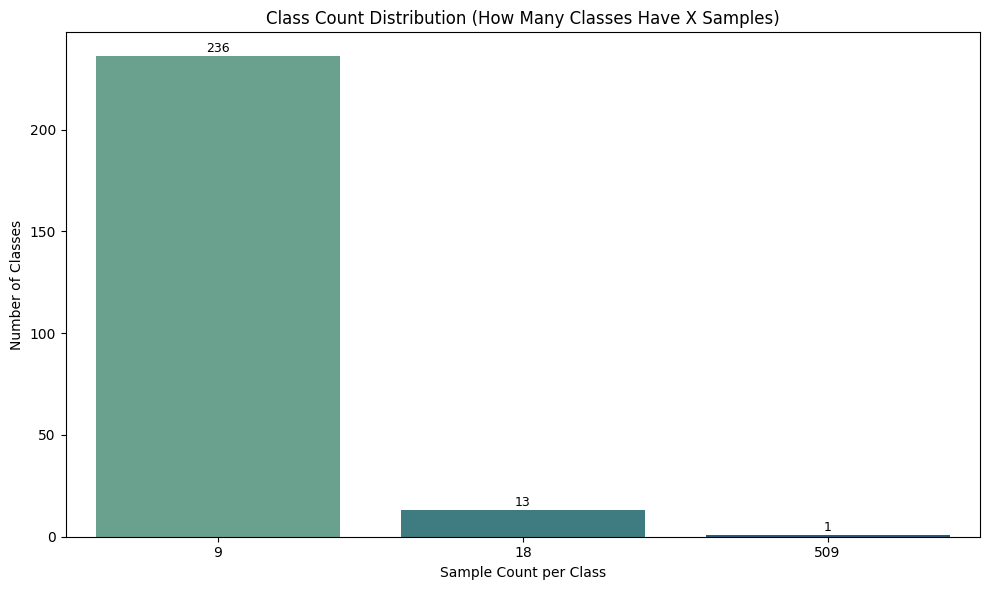

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count how many samples per class
class_counts = df_labeled['Metadata_pert_iname'].value_counts()

# Group by unique count values → how many classes have X samples
count_distribution = class_counts.value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=count_distribution.index, y=count_distribution.values, palette='crest')
plt.xlabel('Sample Count per Class')
plt.ylabel('Number of Classes')
plt.title('Class Count Distribution (How Many Classes Have X Samples)')

# Add count labels
for i, val in enumerate(count_distribution.values):
    ax.text(i, val + 0.5, str(val), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# XGboost with filter data with balance

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === 1. Validation split from X_train for early stopping
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# === 2. Compute class-balanced weights for training
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_split)

# === 3. Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=200,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    early_stopping_rounds=10
)

xgb_model.fit(
    X_train_split,
    y_train_split,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=True
)

# === 4. Predict and evaluate on X_test (same as Random Forest)
y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"\n📊 XGBoost Test Accuracy: {acc_xgb:.4f}\n")
print(classification_report(y_test, y_pred_xgb, target_names=le.inverse_transform(np.unique(y_test))))

[0]	validation_0-mlogloss:2.28620
[1]	validation_0-mlogloss:2.01122
[2]	validation_0-mlogloss:1.80672
[3]	validation_0-mlogloss:1.65980
[4]	validation_0-mlogloss:1.54681
[5]	validation_0-mlogloss:1.42700
[6]	validation_0-mlogloss:1.35669
[7]	validation_0-mlogloss:1.28578
[8]	validation_0-mlogloss:1.23045
[9]	validation_0-mlogloss:1.17357
[10]	validation_0-mlogloss:1.13137
[11]	validation_0-mlogloss:1.09752
[12]	validation_0-mlogloss:1.06285
[13]	validation_0-mlogloss:1.03859
[14]	validation_0-mlogloss:1.01508
[15]	validation_0-mlogloss:0.99527
[16]	validation_0-mlogloss:0.96842
[17]	validation_0-mlogloss:0.95580
[18]	validation_0-mlogloss:0.95096
[19]	validation_0-mlogloss:0.93377
[20]	validation_0-mlogloss:0.91567
[21]	validation_0-mlogloss:0.89881
[22]	validation_0-mlogloss:0.89221
[23]	validation_0-mlogloss:0.88412
[24]	validation_0-mlogloss:0.87917
[25]	validation_0-mlogloss:0.87026
[26]	validation_0-mlogloss:0.86819
[27]	validation_0-mlogloss:0.86514
[28]	validation_0-mlogloss:0.8

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:22:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation_0-mlogloss:0.85643
[31]	validation_0-mlogloss:0.85496
[32]	validation_0-mlogloss:0.85328
[33]	validation_0-mlogloss:0.85080
[34]	validation_0-mlogloss:0.84760
[35]	validation_0-mlogloss:0.84535
[36]	validation_0-mlogloss:0.84452
[37]	validation_0-mlogloss:0.84381
[38]	validation_0-mlogloss:0.84232
[39]	validation_0-mlogloss:0.84285
[40]	validation_0-mlogloss:0.84212
[41]	validation_0-mlogloss:0.83919
[42]	validation_0-mlogloss:0.83682
[43]	validation_0-mlogloss:0.83557
[44]	validation_0-mlogloss:0.83332
[45]	validation_0-mlogloss:0.83355
[46]	validation_0-mlogloss:0.83384
[47]	validation_0-mlogloss:0.83491
[48]	validation_0-mlogloss:0.83598
[49]	validation_0-mlogloss:0.83366
[50]	validation_0-mlogloss:0.83167
[51]	validation_0-mlogloss:0.82904
[52]	validation_0-mlogloss:0.83008
[53]	validation_0-mlogloss:0.82724
[54]	validation_0-mlogloss:0.82600
[55]	validation_0-mlogloss:0.82779
[56]	validation_0-mlogloss:0.82681
[57]	validation_0-mlogloss:0.82455
[58]	validation_0-ml

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# XGBoost with SMOTE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# === Train XGBoost with early stopping ===
xgb_model = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    random_state=42,
    use_label_encoder=False,
    early_stopping_rounds=10,

)

xgb_model.fit(
    X_train_smote,
    y_train_smote,
    eval_set=[(X_test, y_test)],
    verbose=True
)

# === Predict & Evaluate ===
y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nTest Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=le.inverse_transform(np.unique(y_test))))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:47:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:8.82168
[1]	validation_0-mlogloss:8.57819
[2]	validation_0-mlogloss:8.34013
[3]	validation_0-mlogloss:8.21385
[4]	validation_0-mlogloss:8.14286
[5]	validation_0-mlogloss:8.08889
[6]	validation_0-mlogloss:8.05357
[7]	validation_0-mlogloss:8.02660
[8]	validation_0-mlogloss:7.99719
[9]	validation_0-mlogloss:7.99085
[10]	validation_0-mlogloss:7.98690
[11]	validation_0-mlogloss:7.98384
[12]	validation_0-mlogloss:7.97516
[13]	validation_0-mlogloss:7.97971
[14]	validation_0-mlogloss:7.97343
[15]	validation_0-mlogloss:7.97042
[16]	validation_0-mlogloss:7.97603
[17]	validation_0-mlogloss:7.98892
[18]	validation_0-mlogloss:7.99527
[19]	validation_0-mlogloss:7.99663
[20]	validation_0-mlogloss:8.00610
[21]	validation_0-mlogloss:8.00557
[22]	validation_0-mlogloss:8.01115
[23]	validation_0-mlogloss:8.01521
[24]	validation_0-mlogloss:8.02840

Test Accuracy: 0.0941
                                         precision    recall  f1-score   support

                              

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metadata_target
ABL1        2
ADH1C       2
ADRA2B      2
BAX         2
AGER        2
AKR1B1      2
ALDH2       2
AVPR1A      2
ATP5F1D     2
ATM         2
ASIC1       2
BRD4        2
BRAF        2
BTK         2
CCND1       2
CASP3       2
CACNA2D3    2
CA5A        2
CA14        2
USP1        2
TUBB4B      2
TUBB3       2
TGM2        2
TNF         2
CDK4        2
CDK2        2
CDC25A      2
CHRM3       2
CDK9        2
CYP1A2      2
Name: Metadata_pert_iname, dtype: int64


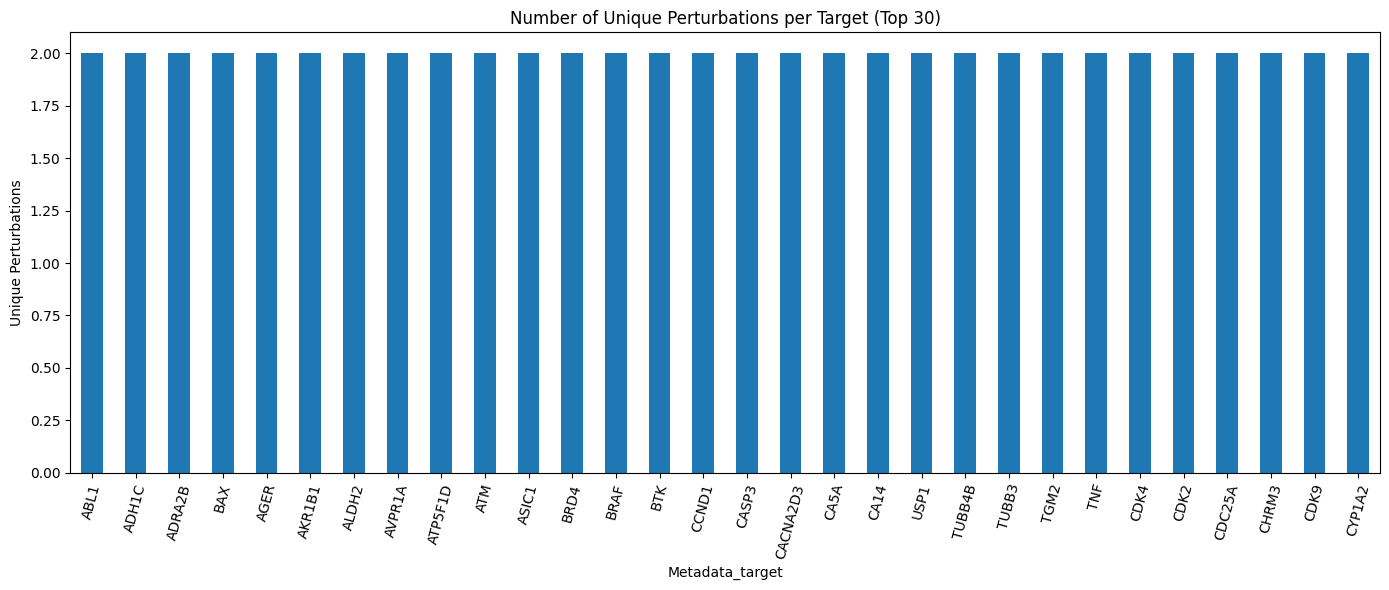

In [ ]:
meta_subset = meta[['image_id', 'Metadata_target', 'Metadata_pert_iname']].dropna().drop_duplicates()
merged = pd.merge(df_all[['image_id']], meta_subset, on='image_id', how='left')

# === Count unique perturbations per target ===
pert_per_target = merged.groupby('Metadata_target')['Metadata_pert_iname'].nunique().sort_values(ascending=False)

# === Display top 30 targets with most perturbations ===
print(pert_per_target.head(30))

# === Plot it ===
plt.figure(figsize=(14, 6))
pert_per_target.head(30).plot(kind='bar')
plt.title("Number of Unique Perturbations per Target (Top 30)")
plt.ylabel("Unique Perturbations")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

In [ ]:
# Count how many targets have more than 2 compounds
target_pert_counts = pert_per_target  # already computed earlier

# Filter those with > 2 unique perturbations
multi_pert_targets = target_pert_counts[target_pert_counts == 1]
print(f"Targets with == 1 unique compounds: {len(multi_pert_targets)}")
print(multi_pert_targets.head(10))


Targets with == 1 unique compounds: 45
Metadata_target
ADORA2A     1
ADA         1
AKR1C1      1
AKT1        1
ANXA1       1
CHEK2       1
CDK7        1
CACNG1      1
CATSPER4    1
CACNB4      1
Name: Metadata_pert_iname, dtype: int64


In [ ]:
# Count how many targets have more than 2 compounds
target_pert_counts = pert_per_target  # already computed earlier

# Filter those with > 2 unique perturbations
multi_pert_targets = target_pert_counts[target_pert_counts == 2]
print(f"Targets with == 2 unique compounds: {len(multi_pert_targets)}")
print(multi_pert_targets.head(10))


Targets with == 2 unique compounds: 102
Metadata_target
ABL1       2
ADH1C      2
ADRA2B     2
BAX        2
AGER       2
AKR1B1     2
ALDH2      2
AVPR1A     2
ATP5F1D    2
ATM        2
Name: Metadata_pert_iname, dtype: int64


In [ ]:
# Count how many targets have more than 2 compounds
target_pert_counts = pert_per_target  # already computed earlier

# Filter those with > 2 unique perturbations
multi_pert_targets = target_pert_counts[target_pert_counts > 2]
print(f"Targets with > 2 unique compounds: {len(multi_pert_targets)}")
print(multi_pert_targets.head(10))


Targets with > 2 unique compounds: 0
Series([], Name: Metadata_pert_iname, dtype: int64)


In [ ]:
model_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/project 2 model/XGBoost_CW"


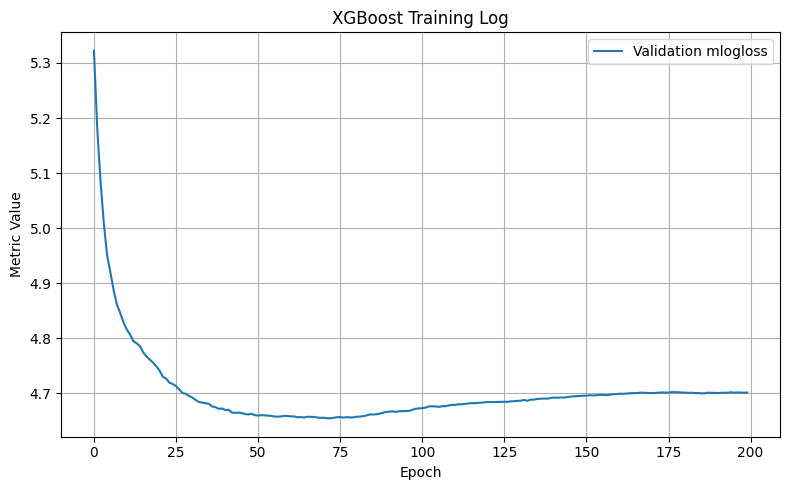

In [1]:
import joblib
import matplotlib.pyplot as plt

# === Load model
model_path = "/content/drive/MyDrive/APPLIED DATA SCIENCE/project 2 model/XGBoost_CW/xgboost_model.joblib"
xgb_model = joblib.load(model_path)

# === Check if evaluation results were saved
if hasattr(xgb_model, 'evals_result'):
    evals_result = xgb_model.evals_result()

    # === Plot log loss
    plt.figure(figsize=(8, 5))
    for key in evals_result['validation_0']:
        plt.plot(evals_result['validation_0'][key], label=f'Validation {key}')
    plt.title("XGBoost Training Log")
    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Evaluation results not found in model. Make sure 'evals_result_' was used during training.")
